In [1]:
#!pip install yfinance

# Stock Portfolio Optimization - Monte Carlo Simulation
## Problem Statement
Select a stock portfolio that minimizes the risk of the portfolio for a given timeframe at a given risk level and provides maximum return. 

The basic Portfolio Optimization problem is to decide how much of an investor’s wealth should be invested in each of the assets of a portfolio in order to reach the Objective of maximizing Sharpe Ratio.


# Data Sources

### yfinance
yfinance uses Yahoo's publicaly available API for making market data available. In this notebook, we are using yfinance python library for accessing historical stock price data.


## Optimization Problem Statement

min -{Conditional Sharpe Ratio} = min -$\{\frac{{R_p} - {R_f}}{CVaR_p,_\alpha}\}$

 subject to:
 
 $\>\>\>\>\>\>\>\>\>{m^T}w \ge {\phi}$
 
 $\>\>\>\>\>\>\>\>\>{e^T}w = 1$
 
 $ \>\>\>\>\>\>\>\>\>{w_i}{\ge} 0$
 
where:
- $R_p$ is the return of the portfolio p
- $R_f$ is the risk-free return
- $CVaR_p,_\alpha$ is portfolio's Conditional Value at Risk at confidence level $\alpha$
- $w$ - vector of portfolio weights
- $m$ - vector of asset returns
- $\phi$ - minimum return from the portfolio, e.g., S&P-500 returns
- $e$ - vector of 1s

## Import Libraries

In [2]:
# import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import pytz as pytz
from dateutil import rrule
from dateutil import relativedelta
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import seaborn as sns
import sqlite3

from scipy import stats
from scipy.stats.mstats import gmean

from sympy.interactive import printing
printing.init_printing(use_latex=True)
import sympy as sp

# Pandas display settings
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

%matplotlib inline
%config InlineBackend.figure_firmat = 'retina'


## Time Window and Other Constants
Our initial target is to use past eight years of stock price data. Later we will revise this window depending on availability of stock price data.

After reviewing yfinance data, we decided to set START_DATE to year 2015 so that it provides (7 * 12) = 84 months of stock price data. 

### Dependency
This Jupyter Notebook assumes that we have successfully loaded all relevant stock data for past eight + years using the other Jupyter Notebook - Stock_portfolio_Oprimization_Exploratory_Data_Analysis_(EDA).jpynb


In [3]:
def get_period_attr(period):
    """
    Gets period attributes, (a) name and (b) window
    Input:
    - period - code representing period type
    Output:
    - name - name of the period
    - window - length of the period in number of months
    - time_unit - time unit for the window; 'day' or 'month'
    """
    # Dictionary for period name
    p_name = {
        'D': 'Daily',
        'W': 'Weekly',
        'M': 'Monthly',
        'Q': 'Quarterly',
        'Y': 'Yearly'
    }
    
    # Dictionary for period window
    p_window = {
        'D': 1,
        'W': 1,
        'M': 1,
        'Q': 3,
        'Y': 12
    }
    
    p_time_unit = {
        'D': 'days',
        'W': 'weeks',
        'M': 'months',
        'Q': 'months',
        'Y': 'months'       
    }
    
    # Get period attributes using dictionaries
    name = p_name.get(period, period + ' not supported')
    window = p_window.get(period, period + ' not supported')
    time_unit = p_time_unit.get(period, period + ' not supported')
    
    # Return period attributes
    return name, window, time_unit


In [4]:
def get_sims_period(sims_freq):
    """
    Returns start and end_date depending on whether east coast market market's session status
    it's session at 4:00 PM Eastern time
    Input:
    - sims_freq - Simulation frequency, currently supported value is 'M' only
    Output:
    - end_date - today or yesterday depending on whether today's market completed it's session 
    """
    current_time = dt.datetime.now()
    local_date = dt.datetime.strftime(current_time, '%b %d, %Y')
    print("Today's date is ........................ " + str(local_date))

    #Prints out the time on the east coast. Helps give context on market hours.    
    eastern_time = dt.datetime.strftime(current_time.astimezone(pytz.timezone('US/Eastern')), '%I:%M %p')

    print("Time on the East Coast is currently .... " + eastern_time)
    day_of_week = dt.datetime.strftime(current_time.astimezone(pytz.timezone('US/Eastern')), '%A')
    print("Today is ............................... " + day_of_week)
    tm_east = int(dt.datetime.strftime(current_time.astimezone(pytz.timezone('US/Eastern')), '%H%M'))
    # Weekend -- Market closed
    if (day_of_week in ("Saturday", "Sunday")):
        print("Market Status .......................... Market Closed")
        end_date = current_time
    # Weekday, time <= 9:30 - Market is yet to open today
    elif (tm_east <= 930):
        print("Market Status .......................... Market Yet to Open")
        end_date = current_time - dt.timedelta(days=1)  
    # Weekday, time >= 16:00 - Market opened but closed now
    elif (tm_east >= 1600):
        print("Market Status .......................... Market has Closed for today")
        end_date = current_time
    # Weekday, market in session
    else:
        print("Market Status .......................... Market is Open")
        end_date = current_time - dt.timedelta(days=1)
    
    if sims_freq == 'M':
        name, window, time_unit = get_period_attr(sims_freq)
        if time_unit == 'days':
            start_date = end_date - dt.timedelta(days=window)
        elif time_unit == 'weeks':
            start_date = end_date - dt.timedelta(weeks=window)
        elif time_unit == 'months':
            start_date = end_date - relativedelta.relativedelta(months=window)
        else:
            start_date = end_date
            print("Fatal error: Not supported " + "sims_freq=" + sims_freq + " time_unit=" + time_unit)            
    else:
        print("Fatal error: Not supported " + "sims_freq=" + sims_freq)

    print("Default Period ......................... " + dt.datetime.strftime(start_date, '%b %d, %Y') \
          + " - " + dt.datetime.strftime(end_date, '%b %d, %Y'))

    return start_date.date(), end_date.date()


In [5]:
# Global constants
SIMS_FREQ = 'M' # Simulation frequency, currently implemented 'M' only
                # Possible values: 'D'-Day, 'W'-Week, 'M'-Month, 'Q'-Quarter, 'Y'-Year, 'A'-Ad Hoc
#  Set default start and end dates
START_DATE, END_DATE = get_sims_period(sims_freq=SIMS_FREQ) 
NUM_SIMS = 100_000 # Number of times Monte Carlo Simulation to be run for a portfolios
DAYS_SIMS = 21 # Number of days simulation is to be run (T)
INIT_INVEST_AMT = 1_000 # Initial investment amount
DISPLAY = False # whether plots and risk measure to be displayed
MC_PLOTS = False # whether MC simulation is to plot visuals
NUM_TRADE_DAYS = 252 # Number of trading days in a year
RISK_FREE_RATE = 0.0397 # Risk free rate is 3.97%
BACK_TEST_YEARS = 7 # Number of years of back testing
SIMS_DATA_VOL = 2_000 # Data volume used for generating mean_returns and covarience_matrix for simulation

# Portfolio template for testing only
ONE_PORTFOLIO = 'GROWTH' # Used for testing on portfolio
ALL_PORTFOLIOS_X = {
    'GROWTH': ['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX']
}

# Portfolio templates
ALL_PORTFOLIOS = {
    # Starter Stock Portfolio
    'STARTER': ['AAPL', 'BRK-B', 'COST', 'GOOGL', 'KO', 'MSFT', 'NEE', 'PFE', 'T'],
    # Large Cap Blue-Chips Portfolio
    'LARGE CAPS': ['AAPL', 'BRK-B','COST', 'GOOGL', 'KO', 'MSFT', 'MCD', 'VZ'],
    # Dividend Stocks Portfolio
    'DIVIDEND': ['CAT', 'CVX', 'JNJ', 'LOW', 'MCD', 'PEP', 'PG', 'TGT', 'WBA', 'WMT'],
    # Value Stock Poprtfolio
    'VALUE': ['AAPL', 'ATVI', 'AXP', 'BAC', 'CVX', 'HPE', 'KO', 'MCO', 'OXY', 'USB'],
    # Growth Stock Portfolio
    'GROWTH': ['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX'],
    # My own stock portfolio
    'MY PORTFOLIO': ['AAPL', 'AMZN', 'GOOGL', 'GS', 'JNJ', 'MSFT', 'PFE'],
    # S&P-500 Proxy - also used for benchmarking
    'S&P-500': ['SPY']
}


# All ticker symbols associated with all Template Portfolios
ALL_SYMBOLS = [] 
for portfolio_name, portfolio_symbols in ALL_PORTFOLIOS.items():
    for symbol in portfolio_symbols:
        if not(symbol in ALL_SYMBOLS):
            ALL_SYMBOLS.append(symbol)

# Seed is set to a fixed value for reproducability of results between runs
SEED = 11
np.random.seed(SEED)

# Database name where prepared data is saved for later use
DB_NAME = 'mcmc.db'
ALL_DAILY_RETURNS_TABLE = 'all_daily_returns'


Today's date is ........................ Apr 14, 2023
Time on the East Coast is currently .... 03:30 PM
Today is ............................... Friday
Market Status .......................... Market is Open
Default Period ......................... Mar 13, 2023 - Apr 13, 2023


## Common Routines

In [6]:
def get_returns(stocks_list, start_date, end_date):
    """
    Routine fetches daily returns data from database
    Input:
    - stocks_list - list of stocks
    - start_date - start date of daily return data
    - start_date - end date of daily return data
    Output:
    - daily_returns_df - dataframe containing daily returns of stocks and inflation data
    """
    # Connect to the SQLITE3 database
    conn = sqlite3.connect(DB_NAME)

    # Read usa_daily_return table from the database
    daily_returns_df = pd.read_sql('SELECT * FROM ' + ALL_DAILY_RETURNS_TABLE, con=conn, parse_dates=['Date'])
    
    # For the dataframe set index to 'Date' column 
    daily_returns_df.set_index('Date', inplace=True)    
    
    daily_returns_df = daily_returns_df[start_date:end_date][stocks_list]

    return daily_returns_df


In [7]:
def mc_VaR(returns, alpha=5):
    """ 
    Input: 
    - returns - pandas series of returns for the underlying portfolio
    - alpha - confidence level for VaR determination
    Output:
    - percentile on return distribution to a confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(mc_VaR, alpha=alpha)
    else:
        raise TypeError("Expected returns array to be a Pandas Series or a DataFrame.")


In [8]:
def mc_CVaR(returns, alpha=5):
    """ 
    Determines expected shortfall below the given confidence level
    Input: 
    - returns - pandas series of returns for the underlying portfolio
    - alpha - confidence level for the CVaR determination
    Output: 
    - CVaR or Expected Shortfall to a given confidence level
    """
    if isinstance(returns, pd.Series):
        belowVaR = (returns <= mc_VaR(returns, alpha=alpha))
        return returns[belowVaR].mean()
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(mc_CVaR, alpha=alpha)
    else:
        raise TypeError("Expected returns array to be a Pandas Series or DataFrame.")


In [9]:
def get_data(stocks_list, start_date, end_date):
    """
    Get mean returns and covariance matrix from returns data
    Input:
    - stocks_list - list of stock for which returns data to be fetched
    - start_date - start date
    - end_date - end date
    Output:
    - mean returns
    - covariance matrix
    """
    # Get returns data
    returns_df = get_returns(stocks_list, start_date, end_date)

    # Calculate mean and covariance matrix
    mean_returns = returns_df.mean()
    cov_matrix = returns_df.cov()
    
    return mean_returns, cov_matrix


In [10]:
def monte_carlo_simulation(portfolio, end_date, days_sims=DAYS_SIMS, num_sims=NUM_SIMS):
    """
    Monte Carlo Simulation of portfolio value movements
    Input:
    - portfolio - portfolio name
    - days_sims - number of days MC simulation to be run
    - num_sims - number of time simulation is to be repeated
    Output:
    - portfolio_sims - simulation results
    - weights_matrix - random weights acumulated in this matrix
    """
    # Setup start and end dates for simulation
    start_date_rets = end_date - dt.timedelta(days=SIMS_DATA_VOL) # Get mult-years data

    # Get list of stocks in the portfolio
    stocks_list = ALL_PORTFOLIOS[portfolio]

    # Number of stocks
    num_stocks = len(stocks_list)

    # Mean returns and covariance matrix
    mean_returns, cov_matrix = get_data(stocks_list, start_date_rets, end_date)
    
    # Initialize mean matrix
    mean_matrix = np.full(shape=(days_sims, num_stocks), fill_value=mean_returns)
    mean_matrix = mean_matrix.T

    # Initialize weights matrix to Numpy zeroes
    weights_matrix = np.full(shape=(num_sims, num_stocks), fill_value=0.0)
    weights_matrix = weights_matrix.T
    
    # Simulation results initialized to numpy zeros
    portfolio_sims = np.full(shape=(days_sims, num_sims), fill_value=0.0)
    
    # Monte Carlo Simulation loop
    for j in range(0, num_sims):
        
        # Assign random weights and normalize
        weights = np.array(np.random.random(num_stocks))
        weights /= np.sum(weights)
        weights_matrix[:,j] = weights

        # Use Cholesky decomposition
        Z = np.random.normal(size=(days_sims, num_stocks))
        L = np.linalg.cholesky(cov_matrix)
        daily_returns = mean_matrix + np.inner(L, Z)

        # Calculate portfolio's value on j-th iteration
        portfolio_sims[:,j] = np.cumprod(np.inner(weights, daily_returns.T) + 1) * INIT_INVEST_AMT

    # Display/supress results per setup
    if MC_PLOTS:
        # Time lapsed visual for MC simulation
        plt.figure(figsize=(8, 5))
        plt.plot(portfolio_sims, linewidth=1)
        #plt.title('Monte Carlo Simulation\nPortfolio ' + portfolio)
        plt.xlabel('Days')
        plt.ylabel('Portfolio Value ($)')
        plt.show()
    
    # Return portfolio_sims
    return portfolio_sims, weights_matrix
    

In [12]:
# For testing and generating MC Plots
#portfolio_sims, weights_matrix = monte_carlo_simulation(ONE_PORTFOLIO, end_date=END_DATE, days_sims=DAYS_SIMS, num_sims=NUM_SIMS)
#portfolio_sims.shape


In [13]:
def get_risk_metrics(portfolio_sims, alpha=5): 
    """
    Calculates risk metrics VaR and CVaR using Monte Carlo Simulation
    Input:
    - portfolio_sims - portfolio_sims simulation results
    - days_sims - number of days MC simulation to be run
    - num_sims - number of time simulation is to be repeated
    - alpha - Confidence interval
    Output:
    - VaR - Value at Risk at confidence interval
    - CVaR - Conditional Value at Risk at confidence interval
    """
    portfolio_results = pd.Series(portfolio_sims[-1,:])
    VaR = INIT_INVEST_AMT - mc_VaR(portfolio_results, alpha=alpha)
    CVaR = INIT_INVEST_AMT - mc_CVaR(portfolio_results, alpha=alpha)

    # Return VaR and CVaR
    return VaR, CVaR


In [14]:
def get_sharps_ratio(portfolio_sims, weights_matrix, CVaR):
    """
    Get Sharpe Ratio and Weights corresponding to max Sharpe Ratio
    Input:
    - portfolio_sims - simulation results
    - weights_matrix - weights matrix
    - CVaR - Conditional Value at Risk for the portfolio
    Output:
    - max_sharpe_ratio - maximum Modified Sharpe Ratio
    - max_sr_return_rate - rate of return for the period corresponding to max Modified Sharpe Ratio 
    - max_sr_port_val - Portfolio value corresponding to max Modified Sharpe ratio
    - max_sr_weights - Portfolio weights corresponding to max Modified Sharpe Ratio
    """
    # Compute Excess Return Rate 
    
    # Apportion risk_free_rate to Monthly
    risk_free_rate_a = (RISK_FREE_RATE / NUM_TRADE_DAYS) * DAYS_SIMS
    
    # Convert CVaR to ratio
    CVaR_ratio = CVaR / INIT_INVEST_AMT
    
    # Calculate portfolio rate of return
    port_return_rate = (portfolio_sims[-1, :] - INIT_INVEST_AMT) / INIT_INVEST_AMT
    
    # Calculate Modified Sharpe Ratio using CVaR ratio as denominator
    sharpe_ratio_mod = (port_return_rate - risk_free_rate_a) / CVaR_ratio

    # Locate max excess return, max_sharpe ratio (modified) and it's location 
    max_sr_loc = np.argmax(sharpe_ratio_mod)
    max_sharpe_ratio = sharpe_ratio_mod[max_sr_loc]
    max_sr_port_val = portfolio_sims[-1, max_sr_loc]
    max_sr_return_rate = port_return_rate[max_sr_loc]

    # Find weights associated to Max Sharpe Ratio 
    max_sr_weights = weights_matrix[:, max_sr_loc]

    # Return max modified Sharpe Ratio, Portfolio Value, and associated weights
    return max_sharpe_ratio, max_sr_return_rate, max_sr_port_val, max_sr_weights


In [15]:
def analyze_portfolios(end_date, days_sims, num_sims):
    """
    Simulate a list of portfolio templates
    Input:
    - end_date - end date of returns data
    - days_sims - number of days for which Monte Carlo simulation to be executed
    - num_sims - number of times simulation loop to be executed
    Output:
    - risk_metrics
    """
    # Perform Monte Carlo simulation for all portfolios in ALL_PORTFOLIOS dictionary
    portfolio_arr, VaR_arr, CVaR_arr, sharpe_ratio_arr, return_rate_arr, \
        port_val_arr, weights_arr = [], [], [], [], [], [], []

    print(f'\nRunning Monte Carlo Simulation on Portfolios')

    # Iterate through portfolios
    for portfolio, stocks_list in ALL_PORTFOLIOS.items(): 
        
        # Perform Monte Carlo Simulation for the portfolio
        portfolio_sims, weights_matrix = monte_carlo_simulation(portfolio, 
                                                                end_date, 
                                                                days_sims, 
                                                                num_sims) 
                
        # Get VaR and CVaR for all portfolios
        VaR, CVaR = get_risk_metrics(portfolio_sims) 
        
        # Get maximum Sharpe Ratio, portfolio value and it's weights
        sharpe_ratio, return_rate, port_val, weights = \
            get_sharps_ratio(portfolio_sims, weights_matrix, CVaR)
        
        # Append portfolio summary data 
        portfolio_arr.append(portfolio)
        VaR_arr.append(round(VaR,2)) 
        CVaR_arr.append(round(CVaR,2))
        sharpe_ratio_arr.append(round(sharpe_ratio,2))
        port_val_arr.append(round(port_val,2))
        return_rate_arr.append(round(return_rate,4))
        weights_arr.append(weights)

    # Construct data frame for all portfolios
    risk_metrics = pd.DataFrame({'Portfolio': portfolio_arr,
                                 'VaR': VaR_arr,
                                 'CVaR': CVaR_arr,
                                 'Sharpe Ratio (M)': sharpe_ratio_arr,
                                 'Value': port_val_arr,
                                 'Return Rate': return_rate_arr,
                                 'Weights': weights_arr})
    risk_metrics.sort_values(by='Sharpe Ratio (M)', ascending=False, inplace=True)
    risk_metrics.set_index(risk_metrics['Portfolio'], drop=True, inplace=True)

    # Save Back Testing results
    risk_metrics.to_csv('Models/PORTOPTIM_Risk_Metrics.csv')

    return risk_metrics


In [16]:
# Perform MC Simulation for all portfolio templates
risk_metrics_df = analyze_portfolios(end_date=END_DATE,
                                     days_sims=DAYS_SIMS,
                                     num_sims=NUM_SIMS)



Running Monte Carlo Simulation on Portfolios


In [17]:
# Print Risk Metrics
if DISPLAY:
    columns = ['VaR', 'CVaR', 'Sharpe Ratio (M)', 'Value']
    print(f"Simulation Summary\n\n{risk_metrics_df[columns]}")


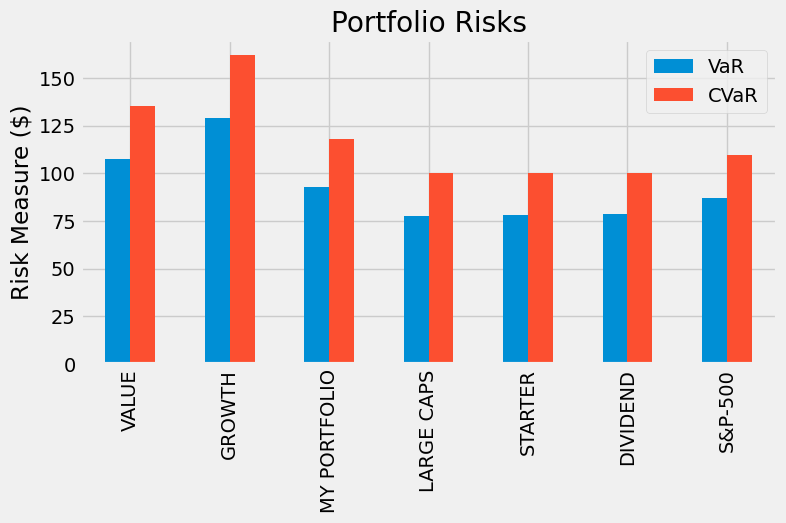

In [18]:
# Plot Portfolio Risk Metrics
columns = ['VaR', 'CVaR']
risk_metrics_df[columns].plot.bar(figsize=(8, 4))
plt.xlabel('')
plt.ylabel('Risk Metric ($)')
plt.title('Portfolio Risks')
plt.show()


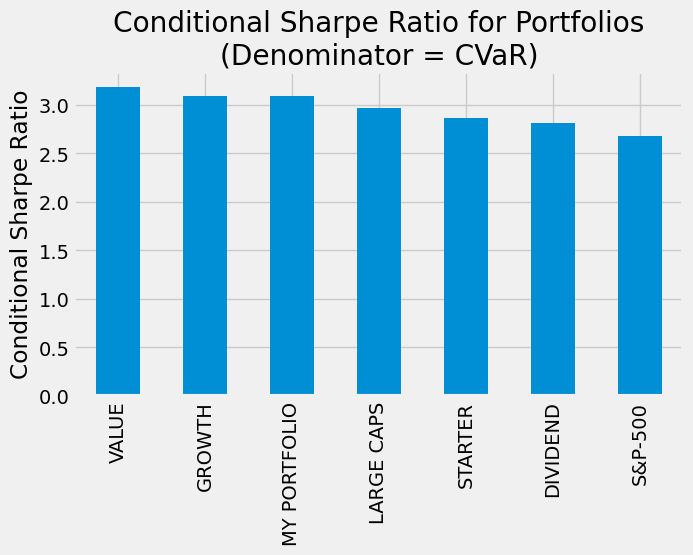

In [19]:
# Plot Portfolio Sharpe Ratios
columns = ['Sharpe Ratio (M)']
risk_metrics_df[columns].plot.bar(figsize=(7, 4), legend=False)
plt.xlabel('')
plt.ylabel('Conditional Sharpe Ratio')
plt.title('Conditional Sharpe Ratio for Portfolios\n(Denominator = CVaR)')
plt.show()


In [20]:
def print_optim_results(df):
    """
    Prints optimum portfolio asset allocation
    """
    # Optimum portfolio and its ticker symbols
    portfolio = df.iloc[0].Portfolio
    port_tickers = ALL_PORTFOLIOS[portfolio]

    # Optimum portfolioweights
    weights = df.iloc[0].Weights
    
    # Construct allocation dataframe
    allocation = pd.DataFrame({'Stock': port_tickers, 'Weight (%)': np.round(weights.astype(float)*100, 2)})
    allocation.sort_values(by='Weight (%)', ascending=False, inplace=True)
    allocation.reset_index(drop=True, inplace=True)
    
    # Print optimum portfolio and it's asset allocation
    print('\nStock Portfolio Optimization\n============================')
    print(f'Run Date/time ..................... {dt.datetime.now()}')
    print(f'Period ............................ {SIMS_FREQ}')     
    print(f'Portfolio (Template) .............. {portfolio}')
    print(f'Days Simulated .................... {DAYS_SIMS}') 
    print(f'Simulation Iterations ............. {NUM_SIMS}')
    print('VaR ............................... $' + str(np.round(df.iloc[0].VaR,2)))
    print('CVaR .............................. $' + str(np.round(df.iloc[0].CVaR,2)))
    print('Sharpe Ratio (CVaR) ............... $' + str(np.round(df.iloc[0]['Sharpe Ratio (M)'],2)))
    print('Investment Amount ................. $' + str(np.round(INIT_INVEST_AMT,2)))
    print('Projected Amount (One Month) ...... $' + str(np.round(df.iloc[0]['Value'],2)))
    print(f'\nAsset Allocation:\n{allocation}')
    
    return allocation
    
    return None


In [21]:
allocation = print_optim_results(risk_metrics_df)


Stock Portfolio Optimization
Run Date/time ..................... 2023-04-14 15:31:10.196324
Period ............................ M
Portfolio (Template) .............. VALUE
Days Simulated .................... 21
Simulation Iterations ............. 100000
VaR ............................... $107.69
CVaR .............................. $135.25
Sharpe Ratio (CVaR) ............... $3.18
Investment Amount ................. $1000
Projected Amount (One Month) ...... $1432.95

Asset Allocation:
  Stock  Weight (%)
0   MCO       17.04
1   CVX       15.49
2   HPE       14.18
3   BAC       11.61
4   OXY       10.22
5    KO        8.24
6  AAPL        7.92
7   USB        7.64
8   AXP        4.01
9  ATVI        3.66


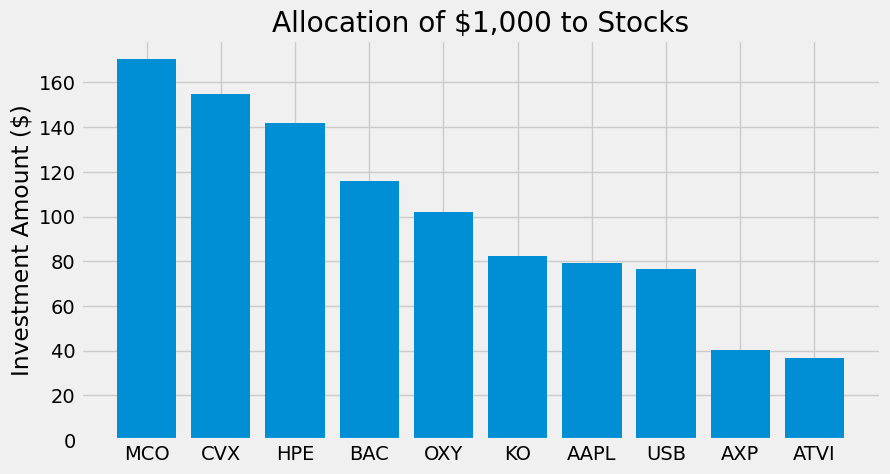

In [22]:
# Plot Allocation data
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
stocks = allocation['Stock']
invest_amt = allocation['Weight (%)'] * INIT_INVEST_AMT / 100
ax.set_title('Allocation of $1,000 to Stocks')
plt.xlabel('')
plt.ylabel('Investment Amount ($)')
ax.bar(stocks, invest_amt)
plt.show()

## Back Testing
Validation is done through back testing. Prior months optimum portfolio and it's weights are used for predicting performances for the month following it. Since Stock Market moves in an unpredictable fashion known as "random walk", we validate effectiveness of Monte Carlo Simulation based Portfolio Optimization by checking that a longer term moving average of optimied portfolio return generally stays above a benchmark. We will use optimum portfolio growth and "S&P-500 Growth" as a benchmark for this validation.


In [23]:
def back_test_top(test_count):
    """
    Each month's trained models are used for predicting subsequest period's optimum 
    portfolio. Results are then stored for agregate level comparison.
    Input:
    - pfo_daily_returns_df - Daily Returns dataframe for a portfolio
    - start_date - Start date of the training data
    - end_date - end date of the training data
    - weights - Weights of portfolio ticker symbols
    Output:
    - pfo_returns - Predicted return for the portfolio 
    - pfo_volatility - Predicted portfolio volatility or standard deviation
    - pfo_sharpe_ratio - Predicted portfolio Sharpe Ratio
    """
    display_columns = ['VaR', 'CVaR', 'Sharpe Ratio (M)', 'Value']

    start_dates, end_dates, start_dates_f, end_dates_f, portfolios, VaRs, CVaRs, \
        sharpe_ratios, return_rates, port_values, weights, return_rates_f, port_values_f \
        = [], [], [], [], [], [], [], [], [], [], [], [], []

    end_date = END_DATE - relativedelta.relativedelta(months=test_count+1)
    port_value_f = INIT_INVEST_AMT

    print(f'\nBACK TESTING - TOP PORTFOLIOS')
    
    for i in range(test_count):
        # Prior period simulation
        end_date += relativedelta.relativedelta(months=1)
        start_date = end_date - relativedelta.relativedelta(months=1) + dt.timedelta(days=1)
        end_date_f = end_date + relativedelta.relativedelta(months=1)
        start_date_f = start_date + relativedelta.relativedelta(months=1)

        print(f'\nPeriod#{i}: {start_date_f}::{end_date_f}')

        # Perform Monte Carlo Simulation for the i-th prior time period 
        risk_metrics_df = analyze_portfolios(end_date,
                                             days_sims=DAYS_SIMS,
                                             num_sims=NUM_SIMS)

        if DISPLAY:
            print(f'\n{risk_metrics_df[display_columns]}')
        
        current = risk_metrics_df.iloc[0]
        stocks_list = ALL_PORTFOLIOS[current['Portfolio']]
                
        # Get data
        mean_returns_f, cov_matrix_f = get_data(stocks_list, start_date, end_date)
        
        # Get daily returns data
        daily_returns_f = get_returns(stocks_list, start_date_f, end_date_f).to_numpy().T
        
        weights_f = current['Weights']
                
        port_value_f = (np.cumprod(np.inner(weights_f, daily_returns_f.T) + 1) * port_value_f)[-1]
        
        start_dates.append(start_date)
        end_dates.append(end_date)
        start_dates_f.append(start_date_f)
        end_dates_f.append(end_date_f)
        portfolios.append(current['Portfolio'])
        VaRs.append(current['VaR'])
        CVaRs.append(current['CVaR'])
        sharpe_ratios.append(current['Sharpe Ratio (M)'])
        return_rates.append(current['Return Rate'])
        port_values.append(current['Value'])
        port_values_f.append(round(port_value_f,2))
        weights.append(current['Weights'])

    # Construct validation summary dataframe
    back_test_top_df = pd.DataFrame({'Start Date': start_dates,
                                     'End Date': end_dates,
                                     'Fwd Start Dt': start_dates_f,
                                     'Fwd End Dt': end_dates_f,
                                     'Portfolio': portfolios,
                                     'VaR': VaRs,
                                     'CVaR': CVaRs,
                                     'Max S.R. (CVaR)': sharpe_ratios,
                                     'PFO Rtn Rt': return_rates,
                                     'PFO Val': port_values,
                                     'Fwd PFO Val': port_values_f,
                                     'Weights': weights})
    
    back_test_top_df['Start Date'] = back_test_top_df['Start Date'].astype('datetime64[ns]')
    back_test_top_df['End Date'] = back_test_top_df['End Date'].astype('datetime64[ns]')
    back_test_top_df['Fwd Start Dt'] = back_test_top_df['Fwd Start Dt'].astype('datetime64[ns]')
    back_test_top_df['Fwd End Dt'] = back_test_top_df['Fwd End Dt'].astype('datetime64[ns]')
    back_test_top_df.set_index('Start Date', inplace=True)
    
    # Save Back Testing Top results
    back_test_top_df.to_csv('Models/PORTOPTIM_Back_Testing_Top.csv')
                            
    return back_test_top_df


In [24]:
back_test_top_df = back_test_top(BACK_TEST_YEARS*12)



BACK TESTING - TOP PORTFOLIOS

Period#0: 2016-04-14::2016-05-13

Running Monte Carlo Simulation on Portfolios

Period#1: 2016-05-14::2016-06-13

Running Monte Carlo Simulation on Portfolios

Period#2: 2016-06-14::2016-07-13

Running Monte Carlo Simulation on Portfolios

Period#3: 2016-07-14::2016-08-13

Running Monte Carlo Simulation on Portfolios

Period#4: 2016-08-14::2016-09-13

Running Monte Carlo Simulation on Portfolios

Period#5: 2016-09-14::2016-10-13

Running Monte Carlo Simulation on Portfolios

Period#6: 2016-10-14::2016-11-13

Running Monte Carlo Simulation on Portfolios

Period#7: 2016-11-14::2016-12-13

Running Monte Carlo Simulation on Portfolios

Period#8: 2016-12-14::2017-01-13

Running Monte Carlo Simulation on Portfolios

Period#9: 2017-01-14::2017-02-13

Running Monte Carlo Simulation on Portfolios

Period#10: 2017-02-14::2017-03-13

Running Monte Carlo Simulation on Portfolios

Period#11: 2017-03-14::2017-04-13

Running Monte Carlo Simulation on Portfolios

Period

In [25]:
columns = ['End Date','Fwd Start Dt','Fwd End Dt','Portfolio','VaR','CVaR','Max S.R. (CVaR)','PFO Rtn Rt','PFO Val','Fwd PFO Val']
back_test_top_df[columns]


,End Date,Fwd Start Dt,Fwd End Dt,Portfolio,VaR,CVaR,Max S.R. (CVaR),PFO Rtn Rt,PFO Val,Fwd PFO Val
Start Date,,,,,,,,,,
2016-03-14,2016-04-13,2016-04-14,2016-05-13,GROWTH,90.61,119.88,3.77,0.4550,1454.97,904.85
2016-04-14,2016-05-13,2016-05-14,2016-06-13,GROWTH,92.96,121.94,3.85,0.4723,1472.34,935.80
2016-05-14,2016-06-13,2016-06-14,2016-07-13,GROWTH,91.41,120.04,3.88,0.4693,1469.34,962.22
2016-06-14,2016-07-13,2016-07-14,2016-08-13,GROWTH,89.84,118.50,3.69,0.4402,1440.16,991.02
2016-07-14,2016-08-13,2016-08-14,2016-09-13,GROWTH,85.91,113.59,3.87,0.4429,1442.95,989.23
2016-08-14,2016-09-13,2016-09-14,2016-10-13,GROWTH,87.21,113.90,4.06,0.4657,1465.71,1033.06
2016-09-14,2016-10-13,2016-10-14,2016-11-13,GROWTH,83.68,110.42,3.70,0.4123,1412.34,1043.38
2016-10-14,2016-11-13,2016-11-14,2016-12-13,GROWTH,86.24,113.00,3.81,0.4341,1434.13,1108.71
2016-11-14,2016-12-13,2016-12-14,2017-01-13,GROWTH,83.84,110.78,4.21,0.4698,1469.83,1175.32


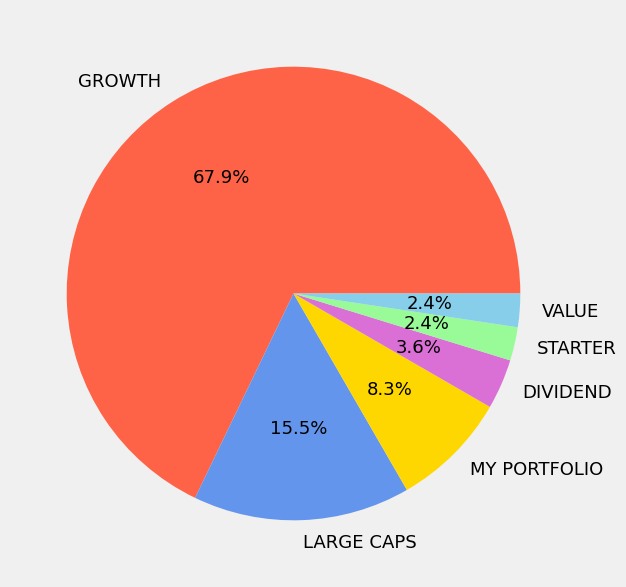

In [26]:
# Plot distribution of optimum portfolios as a pie chart
plt.figure(figsize = (7,7))
plt.title = 'Distribution of Optimum Portfolios'
plt.pie(
    x = back_test_top_df['Portfolio'].value_counts().values,
    labels = back_test_top_df['Portfolio'].value_counts().index.to_list(),
    autopct = '%1.1f%%',
    textprops = {'fontsize':13},
    colors = ['tomato', 'cornflowerblue', 'gold', 'orchid', 'palegreen', 'skyblue', 'cyan', 'tan', 'springgreen', 'orange']
)
plt.show()


In [27]:
# Run backtest for top portfolios
back_test_top_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-03-14 to 2023-02-14
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   End Date         84 non-null     datetime64[ns]
 1   Fwd Start Dt     84 non-null     datetime64[ns]
 2   Fwd End Dt       84 non-null     datetime64[ns]
 3   Portfolio        84 non-null     object        
 4   VaR              84 non-null     float64       
 5   CVaR             84 non-null     float64       
 6   Max S.R. (CVaR)  84 non-null     float64       
 7   PFO Rtn Rt       84 non-null     float64       
 8   PFO Val          84 non-null     float64       
 9   Fwd PFO Val      84 non-null     float64       
 10  Weights          84 non-null     object        
dtypes: datetime64[ns](3), float64(6), object(2)
memory usage: 7.9+ KB


In [28]:
def back_test_all(test_count):
    """
    Each month's trained models are used for predicting subsequest period's optimum 
    portfolio. Results are then stored for agregate level comparison.
    Input:
    - pfo_daily_returns_df - Daily Returns dataframe for a portfolio
    - start_date - Start date of the training data
    - end_date - end date of the training data
    - weights - Weights of portfolio ticker symbols
    Output:
    - pfo_returns - Predicted return for the portfolio 
    - pfo_volatility - Predicted portfolio volatility or standard deviation
    - pfo_sharpe_ratio - Predicted portfolio Sharpe Ratio
    """
    display_columns = ['VaR', 'CVaR', 'Sharpe Ratio (M)', 'Value']

    start_dates_ref, end_dates_ref, start_dates_fwd, end_dates_fwd = [], [], [], [] 
    portfolios_ref, VaRs_ref, CVaRs_ref, sharpe_ratios_ref = [], [], [], []
    port_rtn_rates_ref, port_values_ref, weights_ref = [], [], []
    port_rtn_rates_fwd, port_values_fwd = [], []

    print(f'\nBACK TESTING - ALL PORTFOLIOS')

    # Iterate through portfolios
    for portfolio, stocks_list in ALL_PORTFOLIOS.items(): 
    
        end_date_r = END_DATE - relativedelta.relativedelta(months=test_count+1)

        print(f'\nPortfolio: {portfolio} {stocks_list}')
        # Initialize portfolio value
        port_value_f = INIT_INVEST_AMT
        
        # Iterate through past months
        for i in range(0, test_count):
        
            # Reference period simulation
            end_date_r += relativedelta.relativedelta(months=1)
            start_date_r = end_date_r - relativedelta.relativedelta(months=1) + dt.timedelta(days=1)
            
            # Forward period for back testing
            end_date_f = end_date_r + relativedelta.relativedelta(months=1)
            start_date_f = start_date_r + relativedelta.relativedelta(months=1)

            # Perform MC simulation for the past period
            # =========================================
            
            if DISPLAY:
                print(f'\n\nBPeriod#{i}: {start_date_f}::{end_date_f}')
            
            # Perform Monte Carlo Simulation for the portfolio
            portfolio_sims, weights_matrix = monte_carlo_simulation(portfolio, 
                                                                    end_date_r, 
                                                                    days_sims=DAYS_SIMS, 
                                                                    num_sims=NUM_SIMS) 
                
            # Get VaR and CVaR for all portfolios
            VaR_r, CVaR_r = get_risk_metrics(portfolio_sims) 
        
            # Get maximum Sharpe Ratio, portfolio value and it's weights
            sharpe_ratio_r, rtn_rate_r, port_value_r, weights_r = \
                get_sharps_ratio(portfolio_sims, weights_matrix, CVaR_r)
        
            # Perform Portfolio valuation for the forward period
            # ==================================================
                    
            # Get daily returns data
            daily_returns_f = get_returns(stocks_list, start_date_f, end_date_f).to_numpy().T
            
            # Compute current portfolio value, rate of return for fwd period
            port_value_f *= (np.cumprod(np.inner(weights_r, daily_returns_f.T) + 1))[-1]
            rtn_rate_f = (np.cumprod(1 + daily_returns_f) - 1)[-1]
            
            # Acummulate back test results
            start_dates_ref.append(start_date_r)
            end_dates_ref.append(end_date_r)
            start_dates_fwd.append(start_date_f)
            end_dates_fwd.append(end_date_f)
            portfolios_ref.append(portfolio)
            VaRs_ref.append(round(VaR_r,2))
            CVaRs_ref.append(round(CVaR_r,2))
            sharpe_ratios_ref.append(round(sharpe_ratio_r,2))
            port_values_ref.append(round(port_value_r,2))
            port_rtn_rates_ref.append(round(rtn_rate_r,4))
            port_rtn_rates_fwd.append(round(rtn_rate_f,4))
            port_values_fwd.append(round(port_value_f,2))
            weights_ref.append(weights_r)

    # Construct validation summary dataframe
    back_test_all_df = pd.DataFrame({'Start Date': start_dates_ref,
                                     'End Date': end_dates_ref,
                                     'Fwd Start Dt': start_dates_fwd,
                                     'Fwd End Dt': end_dates_fwd,
                                     'Portfolio': portfolios_ref,
                                     'VaR': VaRs_ref,
                                     'CVaR': CVaRs_ref,
                                     'Max S.R. (CVaR)': sharpe_ratios_ref,
                                     'PFO Rtn Rt': port_rtn_rates_ref,
                                     'PFO Val': port_values_ref,
                                     'Fwd Rtn Rt': port_rtn_rates_fwd,
                                     'Fwd PFO Val': port_values_fwd,
                                     'Weights': weights_ref})
            
    back_test_all_df['Start Date'] = back_test_all_df['Start Date'].astype('datetime64[ns]')
    back_test_all_df['End Date'] = back_test_all_df['End Date'].astype('datetime64[ns]')
    back_test_all_df['Fwd Start Dt'] = back_test_all_df['Fwd Start Dt'].astype('datetime64[ns]')
    back_test_all_df['Fwd End Dt'] = back_test_all_df['Fwd End Dt'].astype('datetime64[ns]')
    back_test_all_df.set_index('Start Date', inplace=True)

    # Save Back Testing All results
    back_test_all_df.to_csv('Models/PORTOPTIM_Back_Testing_All.csv')
     
    return back_test_all_df


In [29]:
# Run back test for all portfolios
back_test_all_df = back_test_all(BACK_TEST_YEARS*12)


BACK TESTING - ALL PORTFOLIOS

Portfolio: STARTER ['AAPL', 'BRK-B', 'COST', 'GOOGL', 'KO', 'MSFT', 'NEE', 'PFE', 'T']

Portfolio: LARGE CAPS ['AAPL', 'BRK-B', 'COST', 'GOOGL', 'KO', 'MSFT', 'MCD', 'VZ']

Portfolio: DIVIDEND ['CAT', 'CVX', 'JNJ', 'LOW', 'MCD', 'PEP', 'PG', 'TGT', 'WBA', 'WMT']

Portfolio: VALUE ['AAPL', 'ATVI', 'AXP', 'BAC', 'CVX', 'HPE', 'KO', 'MCO', 'OXY', 'USB']

Portfolio: GROWTH ['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX']

Portfolio: MY PORTFOLIO ['AAPL', 'AMZN', 'GOOGL', 'GS', 'JNJ', 'MSFT', 'PFE']

Portfolio: S&P-500 ['SPY']


In [30]:
back_test_all_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 2016-03-14 to 2023-02-14
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   End Date         588 non-null    datetime64[ns]
 1   Fwd Start Dt     588 non-null    datetime64[ns]
 2   Fwd End Dt       588 non-null    datetime64[ns]
 3   Portfolio        588 non-null    object        
 4   VaR              588 non-null    float64       
 5   CVaR             588 non-null    float64       
 6   Max S.R. (CVaR)  588 non-null    float64       
 7   PFO Rtn Rt       588 non-null    float64       
 8   PFO Val          588 non-null    float64       
 9   Fwd Rtn Rt       588 non-null    float64       
 10  Fwd PFO Val      588 non-null    float64       
 11  Weights          588 non-null    object        
dtypes: datetime64[ns](3), float64(7), object(2)
memory usage: 59.7+ KB


In [31]:
back_test_all_df[['End Date', 'Portfolio', 'Max S.R. (CVaR)', 'PFO Rtn Rt', 'Fwd Rtn Rt', 'PFO Val', 'Fwd PFO Val']]


,End Date,Portfolio,Max S.R. (CVaR),PFO Rtn Rt,Fwd Rtn Rt,PFO Val,Fwd PFO Val
Start Date,,,,,,,
2016-03-14,2016-04-13,STARTER,2.59,0.2032,-0.2903,1203.16,949.85
2016-04-14,2016-05-13,STARTER,3.14,0.2526,0.2740,1252.59,972.79
2016-05-14,2016-06-13,STARTER,2.98,0.2313,0.3942,1231.27,1007.94
2016-06-14,2016-07-13,STARTER,3.11,0.2369,0.3006,1236.90,1057.63
2016-07-14,2016-08-13,STARTER,2.91,0.2121,-0.2902,1212.09,1013.68
2016-08-14,2016-09-13,STARTER,2.82,0.2094,0.0593,1209.39,1026.32
2016-09-14,2016-10-13,STARTER,2.57,0.1904,-0.1550,1190.37,1009.32
2016-10-14,2016-11-13,STARTER,2.68,0.1978,0.6944,1197.75,1074.26
2016-11-14,2016-12-13,STARTER,3.07,0.2193,0.0067,1219.28,1071.99


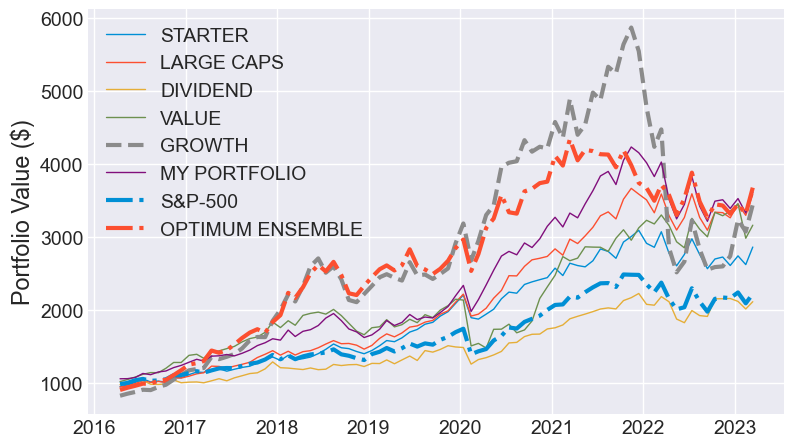

In [40]:
# Plot comparitive historical performance of all portfolios including "Optimum Ensemble"
dates  = back_test_all_df[back_test_all_df['Portfolio'] == 'S&P-500']['Fwd Start Dt'].to_list()
data = back_test_all_df[['Fwd Start Dt', 'Portfolio', 'Fwd PFO Val']]
data.columns = ['Start Date', 'Portfolio', 'Accumulated Value ($)']
optimum_ensemble = back_test_top_df['Fwd PFO Val'].to_list()

# Set up the plot 
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(8,5))
plt.ylabel('Portfolio Value ($)')

# Iterate through portfolios portfolios to construct series objects
for portfolio, stocks_list in ALL_PORTFOLIOS.items(): 
    port_data = data[data['Portfolio'] == portfolio]['Accumulated Value ($)'].to_list()
    if portfolio == 'S&P-500':
        plt.plot(dates, port_data, label=portfolio, linewidth=3, linestyle='-.')
    elif portfolio == 'GROWTH':
        plt.plot(dates, port_data, label=portfolio, linewidth=3, linestyle='--')        
    else:
        plt.plot(dates, port_data, label=portfolio, linewidth=1)

# Plot Optimum Ensemble data from back_test_top_df
plt.plot(dates, optimum_ensemble, label='OPTIMUM ENSEMBLE', linewidth=3, linestyle='-.')

# Now show the plot with legend
plt.legend() 
plt.show()


## End of Notebook: Stock Portfolio Optimization - Monte Carlo Simulation
